In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import exploring_script as es
import importlib
importlib.reload(es)
import pandas as pd
import swifter
import numpy as np
from fink_utils.photometry.vect_conversion import vect_dc_mag

In [3]:
from swifter import set_defaults
set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=False,
    force_parallel=True,
)

In [4]:
confirmed_sso = es.load_data(columns=["ssnamenr", "jd", "nid", "ra", "dec"])

In [7]:
prep_angle = confirmed_sso.drop_duplicates(['ssnamenr', 'nid'])

In [9]:
angle_gb = prep_angle.sort_values("jd").groupby(['ssnamenr'])\
    .agg(
        ra=('ra',list), 
        dec=('dec',list),
        jd=('jd',list),
        nb_det=('ra',lambda x: len(list(x)))
    )

In [12]:
angle_gb = angle_gb[angle_gb["nb_det"] >= 3]

In [15]:
angle_gb["angle"] = angle_gb.swifter.apply(es.angle_df, axis=1)

Pandas Apply:   0%|          | 0/404288 [00:00<?, ?it/s]

/home/roman/Documents/Doctorat/Asteroids/fink-fat/notebook/parameters_selection/exploring_script.py:220: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
angle_gb = angle_gb.explode("angle").reset_index(drop=True)

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


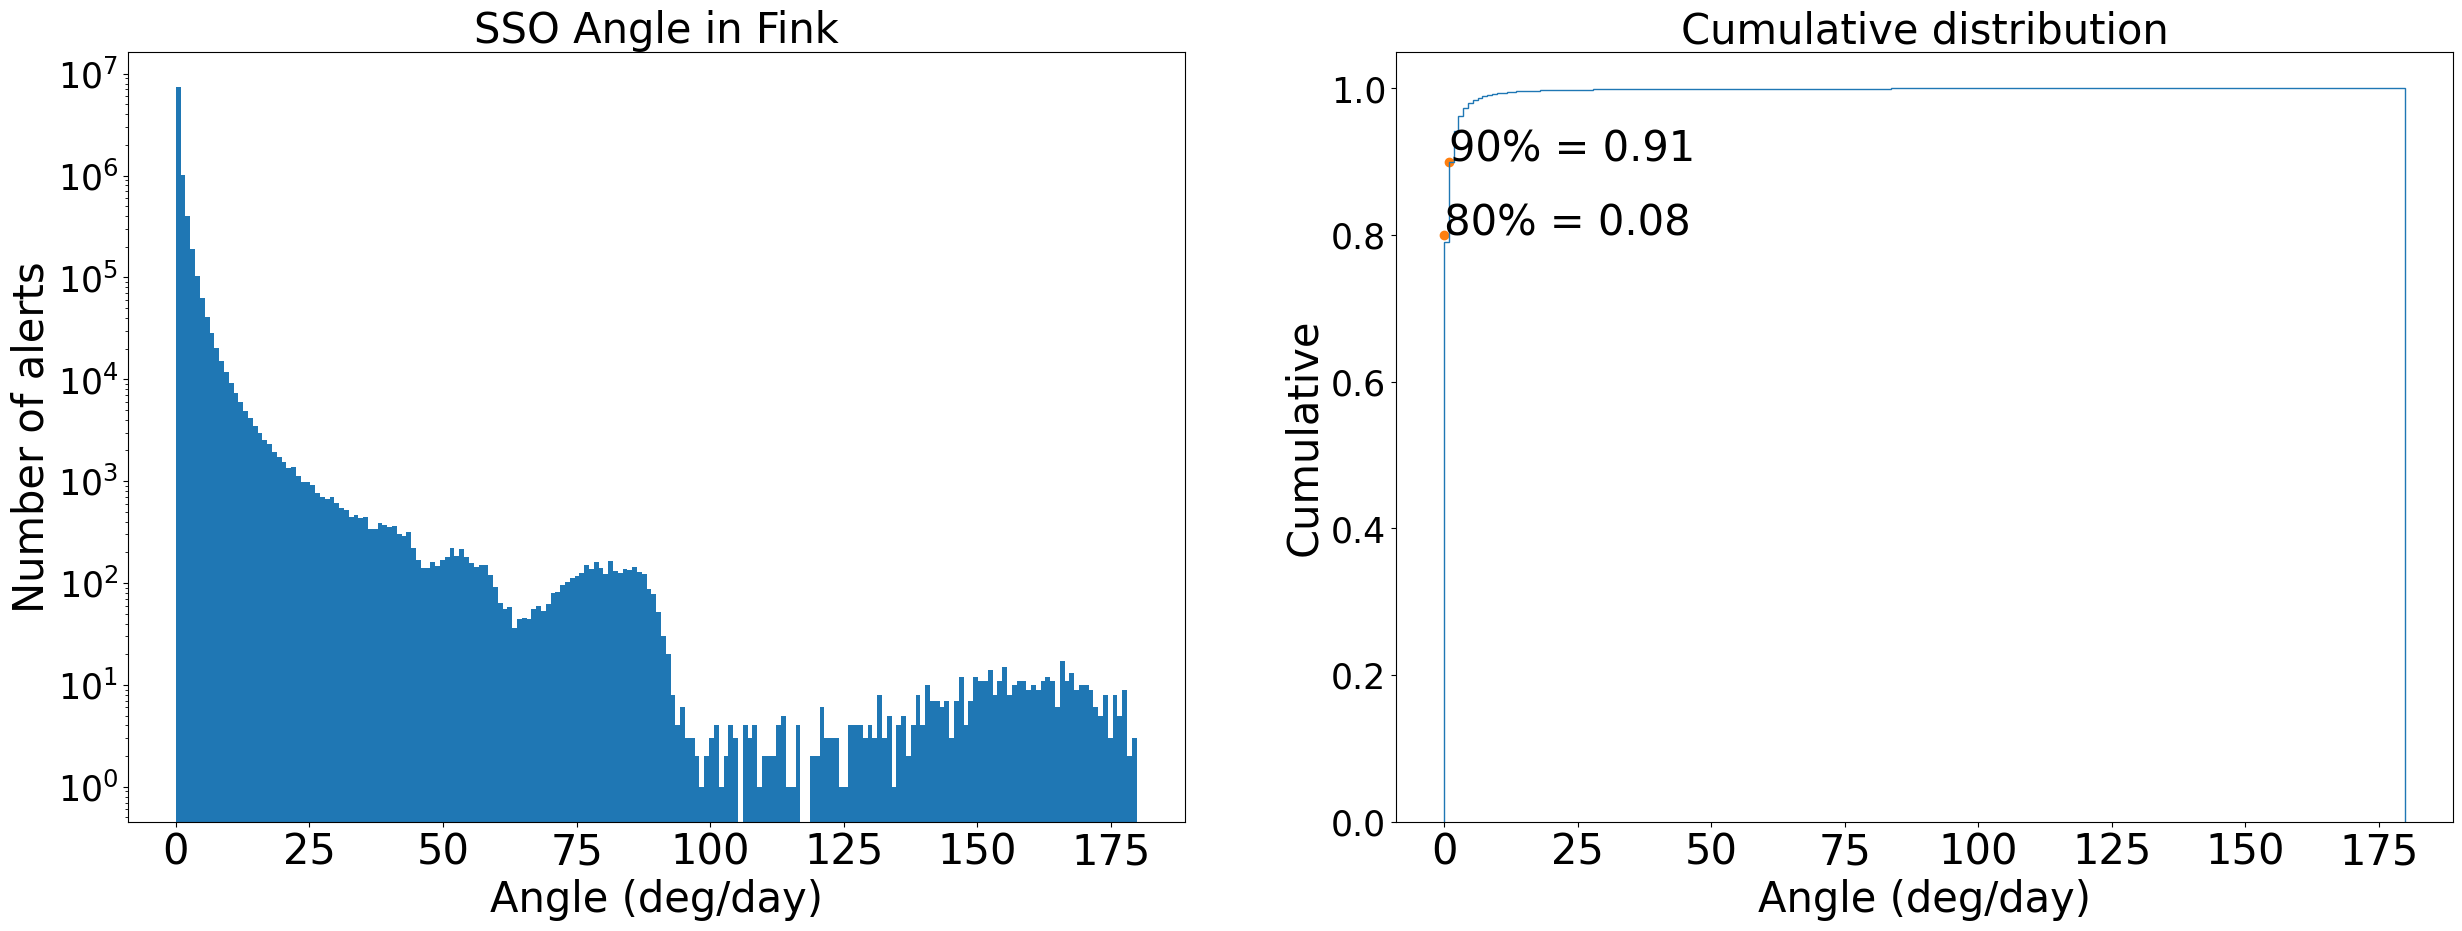

In [21]:
import matplotlib.pyplot as plt
es.plot_hist_and_cdf(angle_gb["angle"], None, "SSO Angle in Fink", "Angle (deg/day)", "Number of alerts", None, "Cumulative distribution", "Angle (deg/day)", "Cumulative")

### NEA Angle

In [5]:
nea_class = ["NEA>Amor", "NEA>Apollo", "NEA>Aten", "NEA>Atira"]

In [6]:
rocks_fink = pd.read_parquet("data/rocks_fink.parquet")
bft_sso = pd.read_parquet(
    "../data/BFT_Miriade/ssoBFT-latest.parquet",
    columns=[
        "sso_name", "sso_class", 
        "orbital_elements.inclination.value",
        "orbital_elements.semi_major_axis.value",
        "orbital_elements.eccentricity.value"
        ]
)

In [7]:
merge_bft_fink = bft_sso.merge(rocks_fink, left_on="sso_name", right_on="ast_name")
merge_bft_fink["ast_number"] = np.nan_to_num(merge_bft_fink["ast_number"], nan=-1.0).astype(int).astype("str")
bft_nea = merge_bft_fink[merge_bft_fink["sso_class"].isin(nea_class)]
nea_fink = bft_nea.merge(confirmed_sso, left_on="ast_number", right_on="ssnamenr")

In [10]:
prep_angle_nea = nea_fink.drop_duplicates(['ssnamenr', 'nid'])

angle_gb = prep_angle_nea.sort_values("jd").groupby(['ssnamenr'])\
    .agg(
        ra=('ra',list), 
        dec=('dec',list),
        jd=('jd',list),
        nb_det=('ra',lambda x: len(list(x)))
)

angle_gb = angle_gb[angle_gb["nb_det"] >= 3]
angle_gb["angle"] = angle_gb.swifter.apply(es.angle_df, axis=1)
angle_gb = angle_gb.explode("angle").reset_index(drop=True)

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


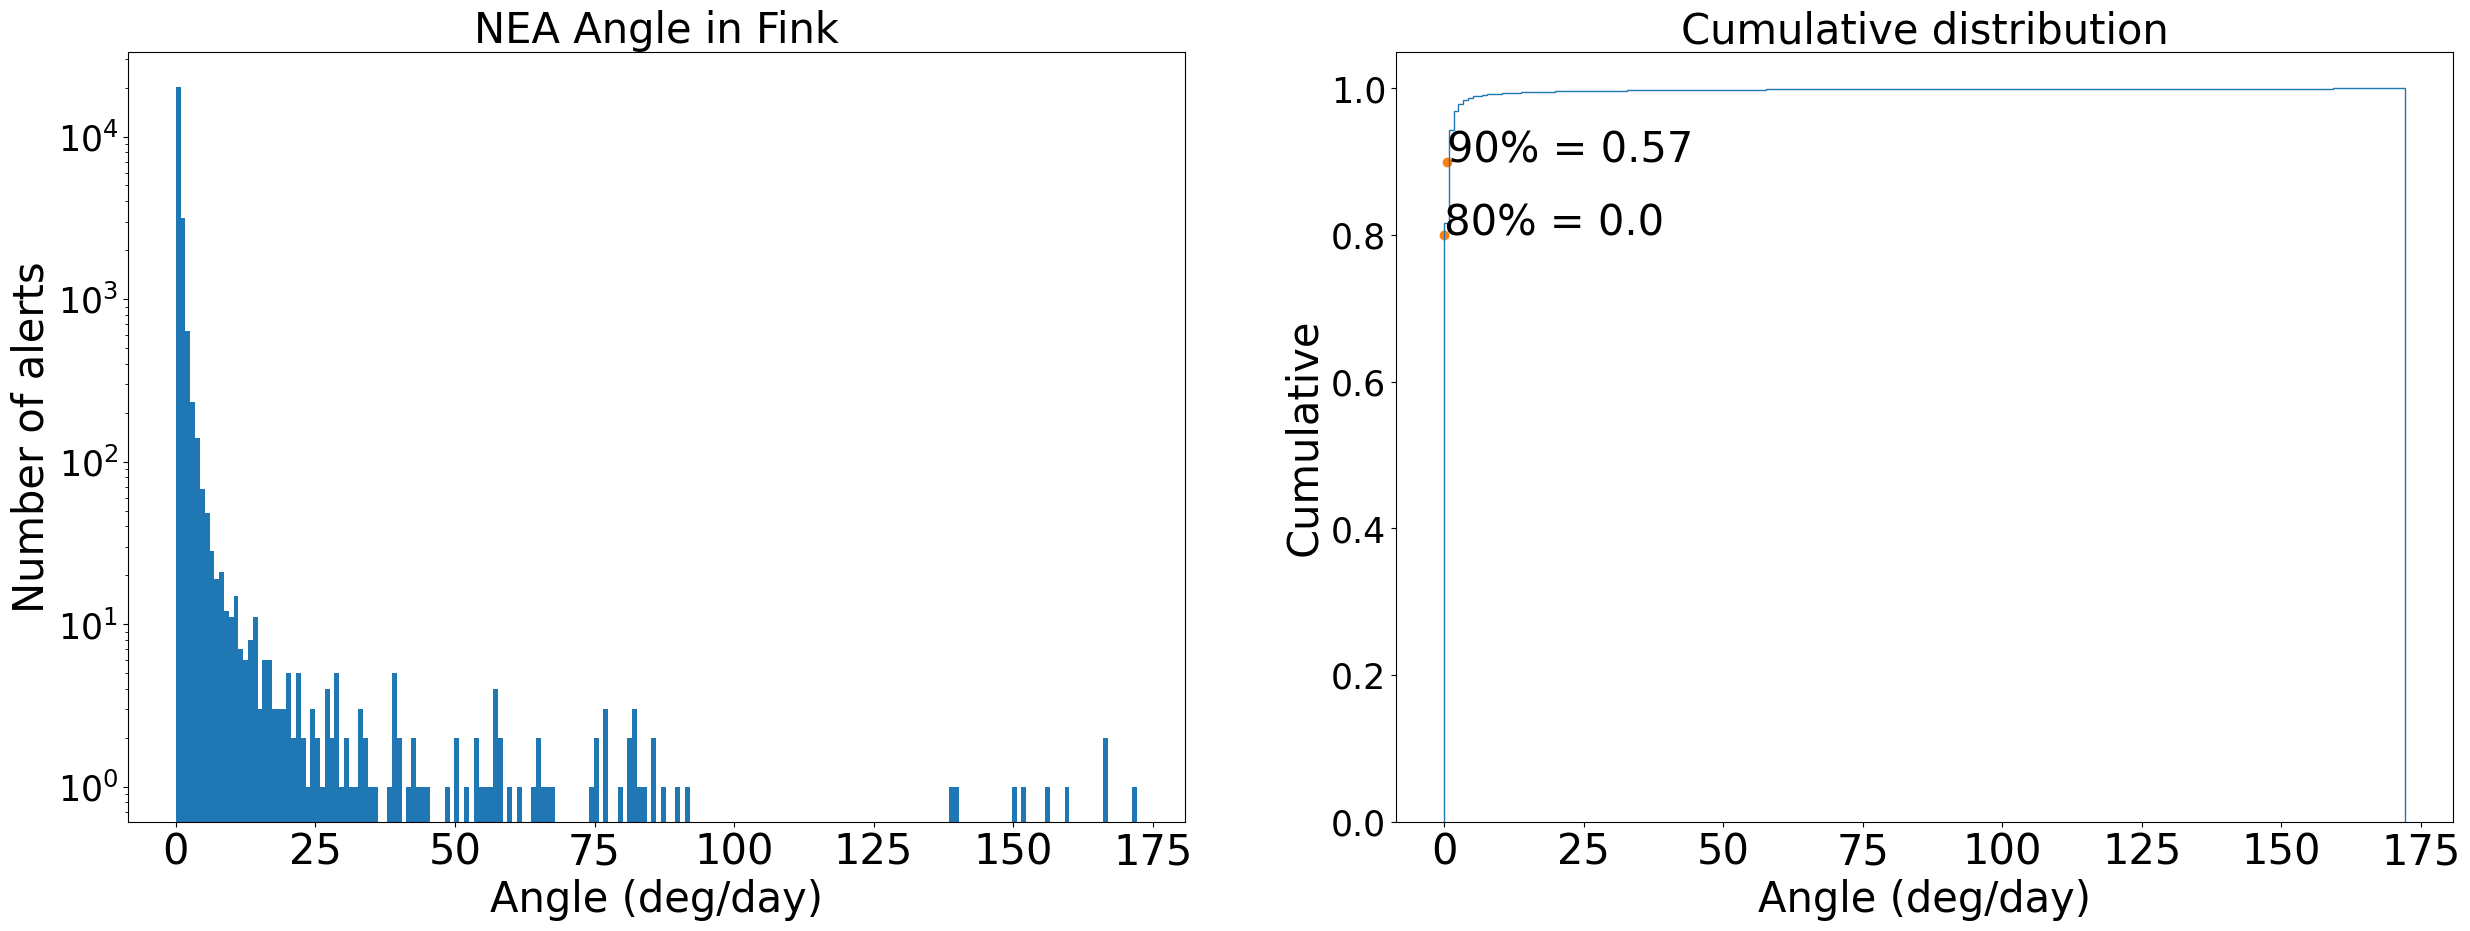

In [11]:
es.plot_hist_and_cdf(
    angle_gb["angle"], 
    None, 
    "NEA Angle in Fink", 
    "Angle (deg/day)", 
    "Number of alerts", None, 
    "Cumulative distribution", 
    "Angle (deg/day)", 
    "Cumulative"
)